# Imports

In [35]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda")
print(device)

cuda


# Load the dataset

In [36]:
train_df = pd.read_csv('dataset/train.csv')
class_names = train_df['label'].unique()
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
print(class_to_idx)

train_df['label'] = train_df['label'].map(class_to_idx)
train_df.to_csv('dataset/train_normalized.csv', index=False)

with open('dataset/classes.txt', 'w') as f:
    for class_name, idx in class_to_idx.items():
        f.write(f'{class_name}: {idx}\n')

print("Classes dictionary saved to classes.txt")
print("The dataset has been loaded.")

{'Badminton': 0, 'Cricket': 1, 'Tennis': 2, 'Swimming': 3, 'Soccer': 4, 'Wrestling': 5, 'Karate': 6}
Classes dictionary saved to classes.txt
The dataset has been loaded.


In [37]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx, 1]
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

batch_size = 32
seed = 42

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=seed)
train_dataset = ImageDataset(dataframe=train_df, img_dir='dataset/train', transform=transform)
val_dataset = ImageDataset(dataframe=val_df, img_dir='dataset/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_df = pd.read_csv('dataset/test.csv')
test_dataset = ImageDataset(dataframe=test_df, img_dir='dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Self made custom neural network model

In [38]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 128)
        
        self.output_layer = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pooling_layer(x)
        
        x = self.relu(self.conv2(x))
        x = self.pooling_layer(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        
        x = self.output_layer(x)
        
        return x


# Training different models for image classification:
- AlexNet
- DenseNet121
- GoogLeNet
- ResNet50
- VGG11
- Custom_model

In [39]:
def initialize_models(num_classes):
    models_dict = {
        "custom_model": {
            "model": CustomModel(num_classes),
            "optimizer": None,
            "name": 'CustomModel'
        },
        "resnet50": {
            "model": models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'ResNet50'
        },
        "vgg11": {
            "model": models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'VGG11'
        },
        "googlenet": {
            "model": models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'GoogLeNet'
        },
        "alexnet": {
            "model": models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'AlexNet'
        },
        "densenet121": {
            "model": models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1),
            "optimizer": None,
            "name": 'DenseNet121'
        }
    }

    for model_key, model_info in models_dict.items():
        model = model_info["model"]
        
        if model_key == "resnet50" or model_key == "googlenet":
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_key == "vgg11" or model_key == "alexnet":
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        elif model_key == "densenet121":
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        elif model_key == "custom_model":
            model.output_layer = nn.Linear(model.output_layer.in_features, num_classes)
        
        if model_key != "custom_model":
            for param in model.parameters():
                param.requires_grad = False

            if model_key == "resnet50" or model_key == "googlenet":
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif model_key == "vgg11" or model_key == "alexnet":
                for param in model.classifier[6].parameters():
                    param.requires_grad = True
            elif model_key == "densenet121":
                for param in model.classifier.parameters():
                    param.requires_grad = True
        
        models_dict[model_key]["model"] = model.to(device)
        models_dict[model_key]["optimizer"] = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    return models_dict


def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc

In [40]:
# Training parameters
num_classes = len(class_names)
models_dict = initialize_models(num_classes)
criterion = nn.CrossEntropyLoss()
best_val_acc_dict = {model_key: 0.0 for model_key in models_dict.keys()}
num_epochs = 10

# Early stopping parameters
patience = 3
counter_without_improvement = {model_key: 0 for model_key in models_dict.keys()}
completed_training_flag = {model_key: False for model_key in models_dict.keys()}

In [41]:
if not os.path.exists('Saved_states/'):
    os.makedirs('Saved_states/')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 60)

    for model_key, model_info in models_dict.items():
        model = model_info["model"]
        optimizer = model_info["optimizer"]
        model_name = model_info["name"]
        
        if (completed_training_flag[model_key] == False):
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
            val_loss, val_acc = evaluate_model(model, val_loader, criterion)
            
            print(f'{model_name} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'{model_name} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
            if val_acc > best_val_acc_dict[model_key]:
                best_val_acc_dict[model_key] = val_acc
                torch.save(model.state_dict(), f'Saved_states/best_{model_key}_model.pth')
                print(f"{model_name} - model saved with improved validation accuracy.")
                counter_without_improvement[model_key] = 0
            else:
                counter_without_improvement[model_key] += 1
                if counter_without_improvement[model_key] >= patience:
                    print(f"{model_name} model has not improved for {patience} epochs. Early stopping.")
                    completed_training_flag[model_key] = True

print("\nTraining phase completed.")

Epoch 1/10
------------------------------------------------------------
CustomModel - Train Loss: 1.7782, Train Acc: 0.2890
CustomModel - Val Loss: 1.4509, Val Acc: 0.4411
CustomModel - model saved with improved validation accuracy.
ResNet50 - Train Loss: 0.7954, Train Acc: 0.7417
ResNet50 - Val Loss: 0.5406, Val Acc: 0.8129
ResNet50 - model saved with improved validation accuracy.
VGG11 - Train Loss: 0.8196, Train Acc: 0.7099
VGG11 - Val Loss: 0.5554, Val Acc: 0.8080
VGG11 - model saved with improved validation accuracy.
GoogLeNet - Train Loss: 1.0970, Train Acc: 0.6616
GoogLeNet - Val Loss: 0.6857, Val Acc: 0.7965
GoogLeNet - model saved with improved validation accuracy.
AlexNet - Train Loss: 0.8415, Train Acc: 0.7014
AlexNet - Val Loss: 0.6351, Val Acc: 0.7855
AlexNet - model saved with improved validation accuracy.
DenseNet121 - Train Loss: 0.9211, Train Acc: 0.7139
DenseNet121 - Val Loss: 0.5040, Val Acc: 0.8657
DenseNet121 - model saved with improved validation accuracy.
Epoch 2

# Model evaluation based on test data


Testowanie modelu: CustomModel
F1 Score for CustomModel: 0.7631


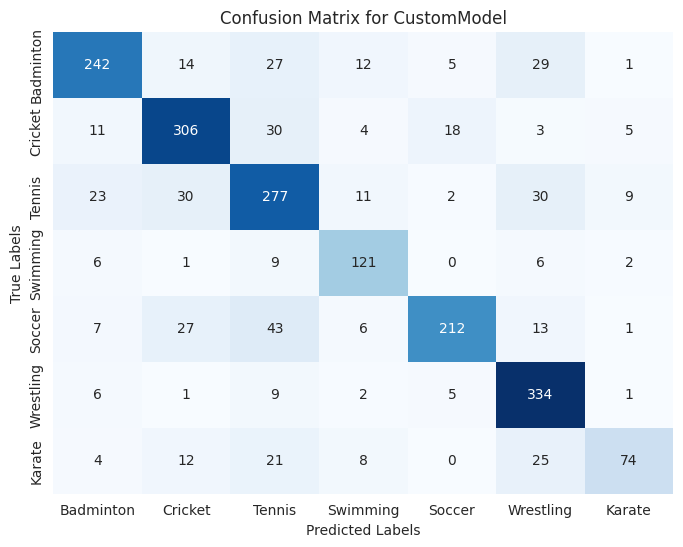


Testowanie modelu: ResNet50
F1 Score for ResNet50: 0.9139


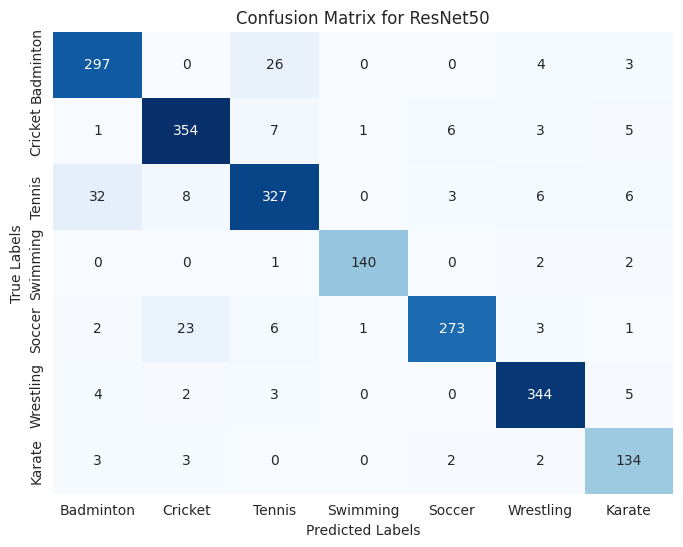


Testowanie modelu: VGG11
F1 Score for VGG11: 0.8728


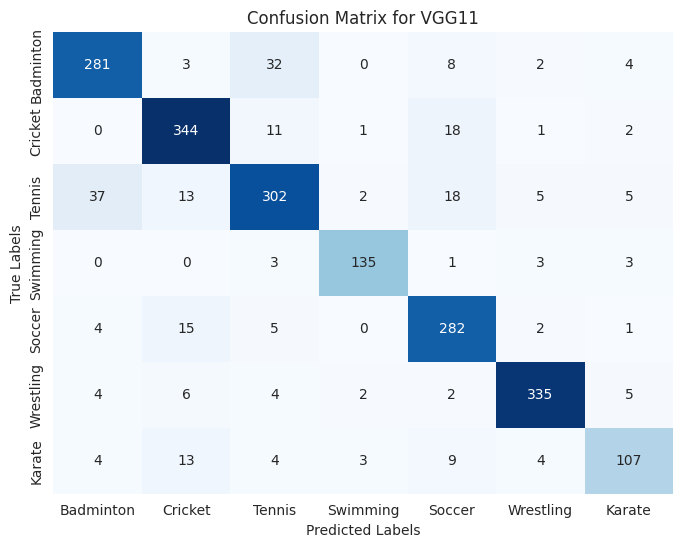


Testowanie modelu: GoogLeNet
F1 Score for GoogLeNet: 0.8726


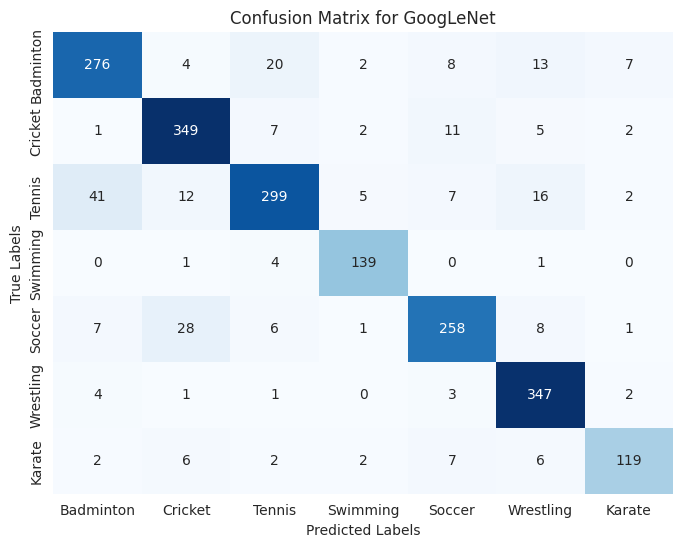


Testowanie modelu: AlexNet
F1 Score for AlexNet: 0.8680


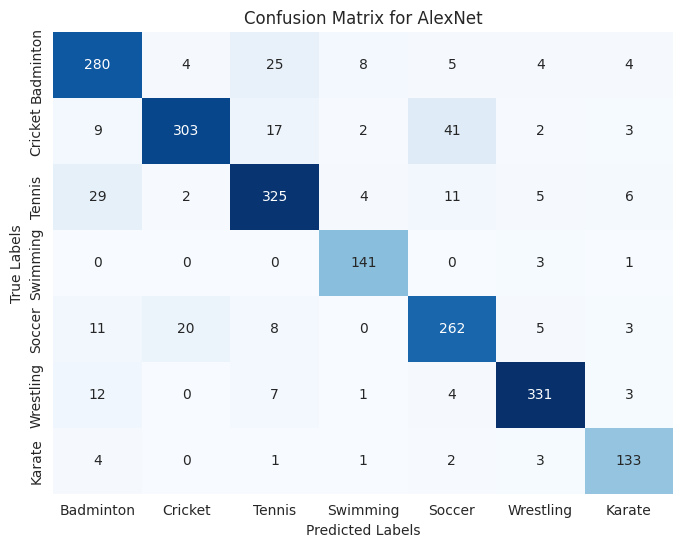


Testowanie modelu: DenseNet121
F1 Score for DenseNet121: 0.9128


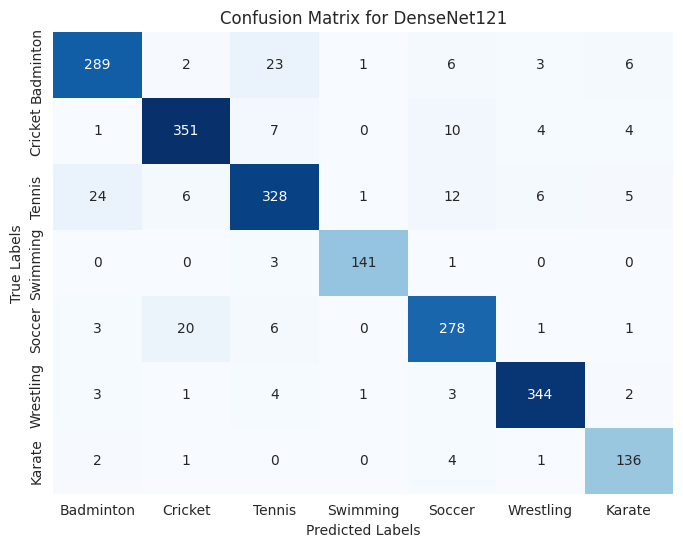

In [42]:
def load_trained_models(num_classes):
    models_dict = initialize_models(num_classes)

    for model_key in models_dict.keys():
        model_path = f'Saved_states/best_{model_key}_model.pth'
        
        if os.path.exists(model_path):
            state_dict = torch.load(model_path, map_location=device, weights_only=True)
            models_dict[model_key]["model"].load_state_dict(state_dict)

    return models_dict


def test_model(model, test_loader, model_name):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'F1 Score for {model_name}: {f1:.4f}')
    
    cm = confusion_matrix(all_labels, all_preds)

    class_names_sorted = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names_sorted, yticklabels=class_names_sorted)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

trained_models_dict = load_trained_models(num_classes)

for model_key, model_info in trained_models_dict.items():
    print(f'\nTestowanie modelu: {model_info["name"]}')
    test_model(model_info["model"], test_loader, model_info["name"])